In [1]:
#Load the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

#load the helping functions
from pipeline_functions import replace_inf_with_nans, standadize_cols_per_subject, replace_with_nan
from pipeline_functions import impute_per_subject,replace_with_ceiling, get_feature_matrix_with_labels

In [2]:
#Load the data and drop the left pupil
subjects_with_conditions_df = pd.read_csv('../subjects_with_conditions_df.csv').drop('Unnamed: 0', axis = 1).drop('left_pupil', axis = 1)

In [3]:
subjects_with_conditions_df.loc[subjects_with_conditions_df['subject']== 1009]

,subject,sample,time,trial,currentobject,rt,right_pupil,right_gaze_x,right_gaze_y,left_gaze_x,left_gaze_y,goal,feedback,reward,bi_goal,bi_feedback,bi_reward,tir_goal,tir_reward,label_7
23740107,1009,1,260392,1,Timer,435,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
23740108,1009,2,260401,1,Timer,435,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
23740109,1009,3,260408,1,Timer,435,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
23740110,1009,4,260418,1,Timer,435,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
23740111,1009,5,260425,1,Timer,435,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23925469,1009,185363,2010282,140,Feedback,383,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
23925470,1009,185364,2010290,140,Feedback,383,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
23925471,1009,185365,2010299,140,Feedback,383,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3
23925472,1009,185366,2010307,140,Feedback,383,NaN,NaN,NaN,NaN,NaN,2,0,0,1.0,NaN,NaN,2.0,NaN,3


In [4]:
#remove subject 1009 since it has 60% broken trials
subjects_with_conditions_df = subjects_with_conditions_df.loc[subjects_with_conditions_df['subject']!= 1009]
subjects_with_conditions_df1 = subjects_with_conditions_df.loc[subjects_with_conditions_df['currentobject']== "Fixation"]

In [5]:
#Data curation- use the ceiling value for RT and gazes to limit high values

ceiling_df = replace_with_ceiling(subjects_with_conditions_df1)

/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [6]:
#Feature engineering - Adding the Deviation feature to the df

ceiling_df['RDEV'] = np.sqrt((ceiling_df['right_gaze_x'] - .5)**2 + (ceiling_df['right_gaze_y'] - .5)**2) 
ceiling_df['LDEV'] = np.sqrt((ceiling_df['left_gaze_x'] - .5)**2 + (ceiling_df['left_gaze_y'] - .5)**2) 

<ipython-input-6-93a0e21d90d8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceiling_df['RDEV'] = np.sqrt((ceiling_df['right_gaze_x'] - .5)**2 + (ceiling_df['right_gaze_y'] - .5)**2)
<ipython-input-6-93a0e21d90d8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ceiling_df['LDEV'] = np.sqrt((ceiling_df['left_gaze_x'] - .5)**2 + (ceiling_df['left_gaze_y'] - .5)**2)


In [7]:
#Feature engineering- Taking means and variances

FE_df =  ceiling_df.groupby(['subject', 'trial']).agg({'right_pupil': ['mean', 'var'], 'LDEV': ['mean', 'var'], 
                                                       'RDEV': ['mean', 'var'],'rt': 'mean' }).reset_index()

In [8]:
FE_df

subject trial right_pupil                LDEV                RDEV  \
                           mean       var      mean       var      mean   
0         845     2    3.731641  0.009510  0.139242  0.001787  0.143712   
1         845     3    3.315353  0.018613  0.147356  0.000508  0.184631   
2         845     4    3.442791  0.003598  0.138801  0.000818  0.135075   
3         845     5    3.177231  0.071958  0.138625  0.000740  0.154326   
4         845     6    3.108376  0.089420  0.153853  0.014132  0.308680   
...       ...   ...         ...       ...       ...       ...       ...   
47009    1246   136    2.729606  0.005430  0.063321  0.000897  0.067020   
47010    1246   137    2.745854  0.004516  0.067167  0.000824  0.050996   
47011    1246   138    2.911762  0.007123  0.060284  0.001404  0.049063   
47012    1246   139    2.831226  0.009292  0.083413  0.001466  0.047057   
47013    1246   140    2.970614  0.030549  0.077364  0.001614  0.048353   

                  rt  
            var mean  
0      0.001325  369  
1      0.000522  336  
2      0.000936  300  
3      0.007994  308  
4      0.012724  354  
...         ...  ...  
47009  0.000299  404  
47010  0.000176  341  
47011  0.000773  298  
47012  0.000743  388  
47013  0.001340  324  

[47014 rows x 9 columns]

In [9]:
# Data imputation

imputed_df = impute_per_subject(FE_df)

In [10]:
#Data standardization. This is done per subject

standardized_df = standadize_cols_per_subject(imputed_df)


/home/mathresearch/pythonVirtualEnv/nethali/nethali/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/mathresearch/pythonVirtualEnv/nethali/Project 2 - Eye data/RT classification/pipeline_functions.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_df[columns[j]] = scaler.fit_transform(subject_df[columns[j]].values.reshape(-1,1))
/home/mathresearch/pythonVirtualEnv/nethali/Project 2 - Eye data/RT classification/pipeline_functions.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [11]:
standardized_df

subject     trial right_pupil                LDEV                RDEV  \
                             mean       var      mean       var      mean   
0     845.0  0.000000    0.684889  0.041297  0.208860  0.009611  0.320946   
1     845.0  0.007246    0.384040  0.094138  0.233713  0.002546  0.427909   
2     845.0  0.014493    0.476139  0.006983  0.207510  0.004259  0.298369   
3     845.0  0.021739    0.284220  0.403793  0.206968  0.003825  0.348690   
4     845.0  0.028986    0.234458  0.505157  0.253613  0.077818  0.752174   
..      ...       ...         ...       ...       ...       ...       ...   
128  1246.0  0.971223    0.362301  0.050061  0.019115  0.002536  0.028477   
129  1246.0  0.978417    0.379193  0.039489  0.023144  0.002303  0.014988   
130  1246.0  0.985612    0.551681  0.069650  0.015934  0.004154  0.013361   
131  1246.0  0.992806    0.467952  0.094740  0.040160  0.004354  0.011672   
132  1246.0  1.000000    0.612868  0.340627  0.033825  0.004824  0.012763   

                  rt  
          var   mean  
0    0.015144  369.0  
1    0.005727  336.0  
2    0.010577  300.0  
3    0.093310  308.0  
4    0.148750  354.0  
..        ...    ...  
128  0.000785  404.0  
129  0.000420  341.0  
130  0.002202  298.0  
131  0.002112  388.0  
132  0.003899  324.0  

[47014 rows x 9 columns]

In [12]:
#rename cols
cols = ['subject', 'trial_no', 'mean_DIAM', 'var_DIAM', 'mean_LDEV', 'var_LDEV', 'mean_RDEV', 'var_RDEV', 'rt']
standardized_df.columns = cols

In [13]:
standardized_df

,subject,trial_no,mean_DIAM,var_DIAM,mean_LDEV,var_LDEV,mean_RDEV,var_RDEV,rt
0,845.0,0.000000,0.684889,0.041297,0.208860,0.009611,0.320946,0.015144,369.0
1,845.0,0.007246,0.384040,0.094138,0.233713,0.002546,0.427909,0.005727,336.0
2,845.0,0.014493,0.476139,0.006983,0.207510,0.004259,0.298369,0.010577,300.0
3,845.0,0.021739,0.284220,0.403793,0.206968,0.003825,0.348690,0.093310,308.0
4,845.0,0.028986,0.234458,0.505157,0.253613,0.077818,0.752174,0.148750,354.0
...,...,...,...,...,...,...,...,...,...
128,1246.0,0.971223,0.362301,0.050061,0.019115,0.002536,0.028477,0.000785,404.0
129,1246.0,0.978417,0.379193,0.039489,0.023144,0.002303,0.014988,0.000420,341.0
130,1246.0,0.985612,0.551681,0.069650,0.015934,0.004154,0.013361,0.002202,298.0
131,1246.0,0.992806,0.467952,0.094740,0.040160,0.004354,0.011672,0.002112,388.0


In [14]:
#Add back the exp conditions

df_with_labels = get_feature_matrix_with_labels(subjects_with_conditions_df, standardized_df)

In [15]:
df_with_labels

,subject,trial_no,mean_DIAM,var_DIAM,mean_LDEV,var_LDEV,mean_RDEV,var_RDEV,rt,goal,feedback,reward
0,845.0,0.000000,0.684889,0.041297,0.208860,0.009611,0.320946,0.015144,369.0,2,0,0
1,845.0,0.007246,0.384040,0.094138,0.233713,0.002546,0.427909,0.005727,336.0,2,0,0
2,845.0,0.014493,0.476139,0.006983,0.207510,0.004259,0.298369,0.010577,300.0,2,0,0
3,845.0,0.021739,0.284220,0.403793,0.206968,0.003825,0.348690,0.093310,308.0,2,0,0
4,845.0,0.028986,0.234458,0.505157,0.253613,0.077818,0.752174,0.148750,354.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
128,1246.0,0.971223,0.362301,0.050061,0.019115,0.002536,0.028477,0.000785,404.0,2,1,0
129,1246.0,0.978417,0.379193,0.039489,0.023144,0.002303,0.014988,0.000420,341.0,2,1,0
130,1246.0,0.985612,0.551681,0.069650,0.015934,0.004154,0.013361,0.002202,298.0,2,1,0
131,1246.0,0.992806,0.467952,0.094740,0.040160,0.004354,0.011672,0.002112,388.0,2,1,0


In [16]:
# Dummy enconding for subject, goal and reward

feature_encoded_df = pd.get_dummies(data= df_with_labels, columns=[ 'goal', 'reward'], drop_first= True)

In [17]:
feature_encoded_df.iloc[:, 0:16]

,subject,trial_no,mean_DIAM,var_DIAM,mean_LDEV,var_LDEV,mean_RDEV,var_RDEV,rt,feedback,goal_1,goal_2,reward_1,reward_2
0,845.0,0.000000,0.684889,0.041297,0.208860,0.009611,0.320946,0.015144,369.0,0,0,1,0,0
1,845.0,0.007246,0.384040,0.094138,0.233713,0.002546,0.427909,0.005727,336.0,0,0,1,0,0
2,845.0,0.014493,0.476139,0.006983,0.207510,0.004259,0.298369,0.010577,300.0,0,0,1,0,0
3,845.0,0.021739,0.284220,0.403793,0.206968,0.003825,0.348690,0.093310,308.0,0,0,1,0,0
4,845.0,0.028986,0.234458,0.505157,0.253613,0.077818,0.752174,0.148750,354.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,1246.0,0.971223,0.362301,0.050061,0.019115,0.002536,0.028477,0.000785,404.0,1,0,1,0,0
129,1246.0,0.978417,0.379193,0.039489,0.023144,0.002303,0.014988,0.000420,341.0,1,0,1,0,0
130,1246.0,0.985612,0.551681,0.069650,0.015934,0.004154,0.013361,0.002202,298.0,1,0,1,0,0
131,1246.0,0.992806,0.467952,0.094740,0.040160,0.004354,0.011672,0.002112,388.0,1,0,1,0,0


In [18]:
feature_encoded_df

,subject,trial_no,mean_DIAM,var_DIAM,mean_LDEV,var_LDEV,mean_RDEV,var_RDEV,rt,feedback,goal_1,goal_2,reward_1,reward_2
0,845.0,0.000000,0.684889,0.041297,0.208860,0.009611,0.320946,0.015144,369.0,0,0,1,0,0
1,845.0,0.007246,0.384040,0.094138,0.233713,0.002546,0.427909,0.005727,336.0,0,0,1,0,0
2,845.0,0.014493,0.476139,0.006983,0.207510,0.004259,0.298369,0.010577,300.0,0,0,1,0,0
3,845.0,0.021739,0.284220,0.403793,0.206968,0.003825,0.348690,0.093310,308.0,0,0,1,0,0
4,845.0,0.028986,0.234458,0.505157,0.253613,0.077818,0.752174,0.148750,354.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,1246.0,0.971223,0.362301,0.050061,0.019115,0.002536,0.028477,0.000785,404.0,1,0,1,0,0
129,1246.0,0.978417,0.379193,0.039489,0.023144,0.002303,0.014988,0.000420,341.0,1,0,1,0,0
130,1246.0,0.985612,0.551681,0.069650,0.015934,0.004154,0.013361,0.002202,298.0,1,0,1,0,0
131,1246.0,0.992806,0.467952,0.094740,0.040160,0.004354,0.011672,0.002112,388.0,1,0,1,0,0


# K-means clustering on RT

In [20]:
#Now this feature matrix will be modified for classification. First get the labels using k-means.
#Attach the k means label
from sklearn.cluster import KMeans
x = np.array(feature_encoded_df['rt']).reshape(-1,1)
kmeans = KMeans(3,random_state=0)
kmeans.fit(x)
identified_clusters = kmeans.fit_predict(x)
identified_clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [21]:
#visualization of different labels
import collections
# getting the elements frequencies using Counter class
elements_count = collections.Counter(identified_clusters)
# printing the element and the frequency
for key, value in elements_count.items():
   print(f"{key}: {value}")

0: 39551
1: 7341
2: 122


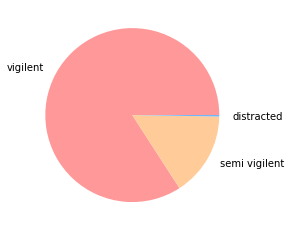

In [22]:
# library
import matplotlib.pyplot as plt

names= ['vigilent', 'semi vigilent', 'distracted']
values = [39551, 7341,  122] #these numbers are coming from above
colors = ['#ff9999','#ffcc99','#66b3ff','#99ff99']
# Create a pieplot
#plt.pie(values)
plt.pie(values, labels=names, labeldistance=1.15, colors = colors)
plt.savefig('K means label.pdf')
plt.show()

In [23]:
#Now add the new RT labels to subjects with conditions df

feature_encoded_df['rt_label_knn1'] = identified_clusters

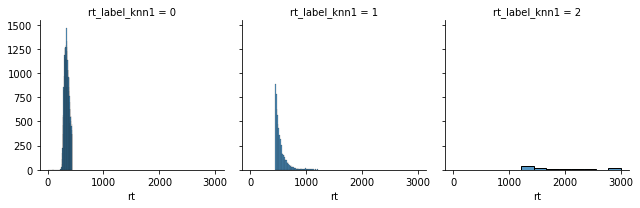

In [24]:
#Checking the distribution of each label
g = sns.FacetGrid(feature_encoded_df, col="rt_label_knn1")
g.map(sns.histplot, "rt")
plt.savefig('KNN_labels.pdf')
#sns.displot(data= temp_df1, x = 'rt', hue = 'rt_label_knn1')

In [25]:
#Checking the distribution of each label
label_ranges = []
for i in range(3):
    label_df = feature_encoded_df.loc[feature_encoded_df['rt_label_knn1'] == i]
    max_rt = label_df['rt'].max()
    min_rt = label_df['rt'].min()
    label_ranges.append((min_rt, max_rt))
label_ranges    

[(6.0, 445.0), (446.0, 1207.0), (1220.0, 3000.0)]

In [26]:
# We can run the code without these conditioning. This is just done to emphasize the boundries 
#OR if there are overlaps and we need to relabel the labels

# drop the old label since this is no longer valid
df = feature_encoded_df.drop(['rt_label_knn1'], axis = 1)
conditions = [
    (df['rt'] <= 445),
    (df['rt'] > 445) & (df['rt'] <= 1207),
    (df['rt'] > 1207) 
    ]

# create a list of the values we want to assign for each condition
values = [0, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
df['rt_label_knn'] = np.select(conditions, values)

In [27]:
# Get the percentages of RTs in each label

percentage_list = []
total_rts = df.shape[0]
for i in range(3):
    temp_df = df.loc[df['rt_label_knn']== i]
    no_of_rts = temp_df.shape[0]
    percentage_list.append(no_of_rts/total_rts)
    
percentage_list

[0.8412600501978135, 0.15614497809163227, 0.002594971710554303]

In [28]:
# Assign df to feature_encoded df (df was used for simplicity)
feature_encoded_df = df

In [29]:
import pandas as pd
import statsmodels.api as sm


def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included


In [30]:
feature_encoded_df.columns

Index(['subject', 'trial_no', 'mean_DIAM', 'var_DIAM', 'mean_LDEV', 'var_LDEV',
       'mean_RDEV', 'var_RDEV', 'rt', 'feedback', 'goal_1', 'goal_2',
       'reward_1', 'reward_2', 'rt_label_knn'],
      dtype='object')

In [31]:
df = feature_encoded_df

features = []

X= df.drop(['rt', 'rt_label_knn', 'subject'], axis =1) 
y= df ['rt_label_knn']
#Now do lazy predict
from sklearn.model_selection import train_test_split
from Lazy_predict_version_Nethali_new import Classification
#%load_ext line_profiler

#feature selection
feature_support = backward_regression(X, y, threshold_out = 0.01)
features.append(feature_support)

#Now run lazy predict on just these features from X_1
X_1 = X.get(feature_support)

random_state = [42, 35, 68, 92, 70] 
balanced_accuracy_for_problem_df_list= []
for i in range(5): #This is for manual cv
    X= X_1.astype('float')
    Y= y.astype('int')
                    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state= random_state[i])
    clf = Classification(verbose=0,ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit( X_train, X_test, Y_train, Y_test)
    balanced_accuracy_for_problem_df_list.append(models.drop(['Accuracy', 'ROC AUC', 'F1 Score', 'Time Taken'], axis = 1).rename(columns={"Balanced Accuracy":str(i)}))
        
#get the resulting concat df
result_df = pd.concat(balanced_accuracy_for_problem_df_list, axis=1)
#get the heighest median 
best_bal_accuracy = result_df.median(axis= 1).max()
best_classifier = result_df.median(axis= 1).idxmax()


 90%|████████▉ | 26/29 [01:40<00:15,  5.04s/it]

[18:43:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [01:38<00:16,  5.49s/it]

[18:45:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [01:39<00:19,  6.59s/it]

[18:46:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [01:32<00:13,  4.60s/it]

[18:48:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [01:35<00:14,  4.77s/it]

[18:50:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 29/29 [01:43<00:00,  3.58s/it]


In [32]:
best_bal_accuracy

0.4271272493472043

In [33]:
best_classifier

'NearestCentroid'

In [34]:
result_df

,0,1,2,3,4
Model,,,,,
NearestCentroid,0.43,0.44,0.41,0.42,0.43
Perceptron,0.38,0.35,0.37,0.33,0.37
DecisionTreeClassifier,0.36,0.35,0.34,0.35,0.34
ExtraTreeClassifier,0.34,0.34,0.34,0.35,0.34
BaggingClassifier,0.34,0.34,0.34,0.34,0.34
KNeighborsClassifier,0.34,0.34,0.34,0.34,0.34
GaussianNB,0.34,0.33,0.33,0.35,0.34
RandomForestClassifier,0.34,0.34,0.34,0.34,0.34
ExtraTreesClassifier,0.34,0.34,0.34,0.33,0.34


In [35]:
features

[['trial_no',
  'mean_RDEV',
  'var_RDEV',
  'feedback',
  'goal_1',
  'goal_2',
  'reward_1']]

In [36]:
len(features[0])

7

In [37]:
#saving the KNN features as a list
features_KNN = features
np.save('features_KNN', features_KNN, allow_pickle=True, fix_imports=True)

In [38]:
#parameter tuning
#Nearest Centroid parameter tuning
#list the parameters I want to tune and their values
from sklearn.metrics import zero_one_loss, make_scorer
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
z1_scorer = make_scorer(zero_one_loss, normalize = False)

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

def tune_near_cent_para(X, Y):
    from sklearn.neighbors import NearestCentroid
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import balanced_accuracy_score
    distances_list = ['manhattan', 'euclidean']
    shrinkthres_list = [0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1, None]
   #keys and values for the dictionary
    keys = []
    values = []
    std_list = []
    aic_list = []
    for i in range(len(distances_list)):
        for j in range(len(shrinkthres_list)):
            model = NearestCentroid(metric= distances_list[i], shrink_threshold= shrinkthres_list[j] )
            keys.append(str(i)+str(j))
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
            cv_results = cross_validate(model, X, Y, cv=cv, return_estimator=True, scoring= 'balanced_accuracy') #X,Y same as above
            
            cv_results2 = cross_validate(model, X, Y, cv=cv, return_estimator=True, scoring= z1_scorer)
            z1_mean = cv_results2['test_score'].mean()
            splits = [(x,y) for x, y in cv.split(X, Y)] #This gives the train and test arrays 
            n_train_samples = len(splits[0][0]) #this will give the train sample length
            aic = 2*X.shape[1] + n_train_samples*np.log(z1_mean/ n_train_samples)
            aic_list.append(aic)
            
            accu = cv_results['test_score'].mean()
            std = cv_results['test_score'].std()
            values.append(accu)
            std_list.append(std)

    dict_nearestcent = dict(zip(keys, values)) 
    best_accuracy = max(dict_nearestcent.values())
    index_of_best_acc = np.argmax(dict_nearestcent.values()) 
    best_params_combo = [k for k, v in dict_nearestcent.items() if v == max(dict_nearestcent.values())]
    # Getting the best std
    best_std = std_list[index_of_best_acc]
    best_aic = aic_list [index_of_best_acc]
    
    return(best_accuracy, best_params_combo, best_std , best_aic)

In [39]:
best_accuracy, best_params_combo , best_std, best_aic = tune_near_cent_para(X, Y)

In [40]:
best_accuracy, best_params_combo , best_std, best_aic

(0.44090308834383424, ['10', '18'], 0.04843597800900126, -121998.47139675496)

# Gaussian method

In [41]:
#Finding the right number of clusters
from sklearn.mixture import GaussianMixture
x = np.array(feature_encoded_df['rt']).reshape(-1,1)
gm = GaussianMixture(3, random_state=0)
gm.fit(x)
identified_clusters_gm = gm.fit_predict(x)
identified_clusters_gm

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
#visualization of different labels
import collections
# getting the elements frequencies using Counter class
elements_count = collections.Counter(identified_clusters_gm)
# printing the element and the frequency
for key, value in elements_count.items():
   print(f"{key}: {value}")

0: 39150
2: 7365
1: 499


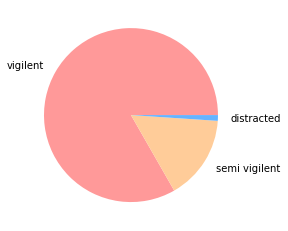

In [43]:
# library
import matplotlib.pyplot as plt

names= ['vigilent', 'semi vigilent', 'distracted']
values = [39150, 7365,  499] #these numbers are coming from above
colors = ['#ff9999','#ffcc99','#66b3ff','#99ff99']
# Create a pieplot
#plt.pie(values)
plt.pie(values, labels=names, labeldistance=1.15, colors = colors)
plt.savefig('Gaussian label.pdf')
plt.show()

In [44]:
feature_encoded_df['rt_label_gaussian1'] = identified_clusters_gm

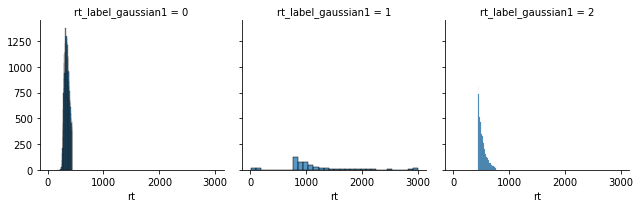

In [45]:
#Checking the distribution of each label
g = sns.FacetGrid(feature_encoded_df, col="rt_label_gaussian1")
g.map(sns.histplot, "rt")

#sns.displot(data= temp_df1, x = 'rt', hue = 'rt_label_knn1')

In [46]:
#Checking the distribution of each label
label_ranges = []
for i in range(3):
    label_df = feature_encoded_df.loc[feature_encoded_df['rt_label_gaussian1'] == i]
    max_rt = label_df['rt'].max()
    min_rt = label_df['rt'].min()
    label_ranges.append((min_rt, max_rt))
label_ranges    

[(171.0, 441.0), (6.0, 3000.0), (442.0, 769.0)]

In [47]:
# Counting the number of values in label 1 that overlap with label 0

temp_df = feature_encoded_df.loc[(feature_encoded_df['rt_label_gaussian1'] == 1) & (feature_encoded_df['rt'] < 442)]
temp_df.shape[0]/ feature_encoded_df.shape[0]

0.0007444590972901689

In [48]:
# Re-label the revised labels in KNN

df = feature_encoded_df.drop(['rt_label_gaussian1'], axis = 1)
conditions = [
    (df['rt'] <= 441),
    (df['rt'] > 441) & (df['rt'] <= 769),
    (df['rt'] > 769) 
    ]

# create a list of the values we want to assign for each condition
values = [0, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
df['rt_label_gaussian'] = np.select(conditions, values)

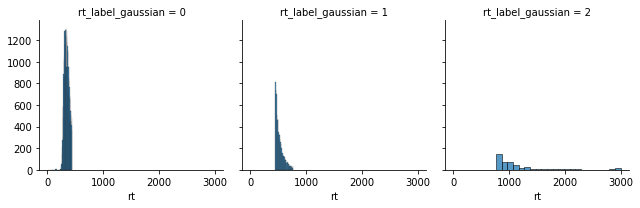

In [49]:
#Checking the distribution of each label (revised)
g = sns.FacetGrid(df, col="rt_label_gaussian")
g.map(sns.histplot, "rt")
plt.savefig('Gaussian_labels.pdf')
#sns.displot(data= temp_df1, x = 'rt', hue = 'rt_label_knn1')

In [50]:
# Get the percentages of RTs in each revised label

percentage_list = []
total_rts = df.shape[0]
for i in range(3):
    temp_df = df.loc[df['rt_label_gaussian']== i]
    no_of_rts = temp_df.shape[0]
    percentage_list.append(no_of_rts/total_rts)
    
percentage_list

[0.8334751350661506, 0.15665546432977412, 0.009869400604075382]

In [51]:
# Assign df to feature_encoded df (df was used for simplicity)
feature_encoded_df = df

In [52]:
df = feature_encoded_df

features = []

X= df.drop(['rt','subject', 'rt_label_knn', 'rt_label_gaussian'], axis =1) 
y= df ['rt_label_gaussian']
#Now do lazy predict
from sklearn.model_selection import train_test_split
from Lazy_predict_version_Nethali_new import Classification
#%load_ext line_profiler

#feature selection
feature_support = backward_regression(X, y, threshold_out = 0.01)
features.append(feature_support)

#Now run lazy predict on just these features from X_1
X_1 = X.get(feature_support)

random_state = [42, 35, 68, 92, 70] 
balanced_accuracy_for_problem_df_list= []
for i in range(5): #This is for manual cv
    X= X_1.astype('float')
    Y= y.astype('int')
                    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state= random_state[i])
    clf = Classification(verbose=0,ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit( X_train, X_test, Y_train, Y_test)
    balanced_accuracy_for_problem_df_list.append(models.drop(['Accuracy', 'ROC AUC', 'F1 Score', 'Time Taken'], axis = 1).rename(columns={"Balanced Accuracy":str(i)}))
#get the resulting concat df
result_df = pd.concat(balanced_accuracy_for_problem_df_list, axis=1)
#get the heighest median 
best_bal_accuracy = result_df.median(axis= 1).max()
best_classifier = result_df.median(axis= 1).idxmax()

 90%|████████▉ | 26/29 [01:38<00:16,  5.58s/it]

[19:02:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [01:35<00:16,  5.44s/it]

[19:03:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [01:35<00:17,  5.99s/it]

[19:05:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [01:36<00:14,  4.78s/it]

[19:07:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [01:36<00:14,  4.82s/it]

[19:09:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 29/29 [01:43<00:00,  3.56s/it]


In [53]:
best_bal_accuracy

0.4109135646068345

In [54]:
best_classifier

'NearestCentroid'

In [55]:
result_df

,0,1,2,3,4
Model,,,,,
NearestCentroid,0.43,0.43,0.39,0.41,0.41
Perceptron,0.39,0.34,0.35,0.36,0.34
PassiveAggressiveClassifier,0.36,0.33,0.37,0.33,0.33
DecisionTreeClassifier,0.35,0.35,0.35,0.34,0.34
ExtraTreeClassifier,0.35,0.34,0.34,0.35,0.35
BaggingClassifier,0.34,0.34,0.34,0.34,0.34
GaussianNB,0.34,0.34,0.34,0.34,0.34
KNeighborsClassifier,0.34,0.34,0.34,0.34,0.34
ExtraTreesClassifier,0.34,0.34,0.34,0.34,0.34


In [56]:
features

[['trial_no',
  'mean_RDEV',
  'var_RDEV',
  'feedback',
  'goal_1',
  'goal_2',
  'reward_1']]

In [57]:
len(features[0])

7

In [58]:
#parameter tuning
#Nearest Centroid parameter tuning
#list the parameters I want to tune and their values

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

def tune_near_cent_para(X, Y):
    from sklearn.neighbors import NearestCentroid
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import balanced_accuracy_score
    distances_list = ['manhattan', 'euclidean']
    shrinkthres_list = [0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1, None]
   #keys and values for the dictionary
    keys = []
    values = []
    std_list = []
    aic_list = []
    for i in range(len(distances_list)):
        for j in range(len(shrinkthres_list)):
            model = NearestCentroid(metric= distances_list[i], shrink_threshold= shrinkthres_list[j] )
            keys.append(str(i)+str(j))
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
            cv_results = cross_validate(model, X, Y, cv=cv, return_estimator=True, scoring= 'balanced_accuracy') #X,Y same as above
            
            cv_results2 = cross_validate(model, X, Y, cv=cv, return_estimator=True, scoring= z1_scorer)
            z1_mean = cv_results2['test_score'].mean()
            splits = [(x,y) for x, y in cv.split(X, Y)] #This gives the train and test arrays 
            n_train_samples = len(splits[0][0]) #this will give the train sample length
            aic = 2*X.shape[1] + n_train_samples*np.log(z1_mean/ n_train_samples)
            aic_list.append(aic)
            
            accu = cv_results['test_score'].mean()
            std = cv_results['test_score'].std()
            values.append(accu)
            std_list.append(std)

    dict_nearestcent = dict(zip(keys, values)) 
    best_accuracy = max(dict_nearestcent.values())
    index_of_best_acc = np.argmax(dict_nearestcent.values()) 
    best_params_combo = [k for k, v in dict_nearestcent.items() if v == max(dict_nearestcent.values())]
    # Getting the best std
    best_std = std_list[index_of_best_acc]
    best_aic = aic_list [index_of_best_acc]
    
    return(best_accuracy, best_params_combo, best_std , best_aic)

In [59]:
best_accuracy, best_params_combo, best_std, best_aic  = tune_near_cent_para(X, Y)

In [60]:
best_accuracy, best_params_combo, best_std, best_aic 

(0.41878790553066814, ['10', '18'], 0.019918216144862104, -121941.29663138867)

# simple 1 classification (balanced)

In [61]:
#This df will be the one used in simple1 
sorted_df = feature_encoded_df.sort_values(by=['rt']) #sorts rt in ascending order

In [62]:
sorted_df.columns

Index(['subject', 'trial_no', 'mean_DIAM', 'var_DIAM', 'mean_LDEV', 'var_LDEV',
       'mean_RDEV', 'var_RDEV', 'rt', 'feedback', 'goal_1', 'goal_2',
       'reward_1', 'reward_2', 'rt_label_knn', 'rt_label_gaussian'],
      dtype='object')

In [63]:
#Making a list of dummy labels
import itertools
list0 =  [0] * int(sorted_df.shape[0]/3)
list1 = [1] * int(sorted_df.shape[0]/3)
list2 = [2] * int(sorted_df.shape[0]/3)

In [64]:
#Append the last rt to list2 #since 47014 is not divisible by 3 , we have 1 left-add it to the last label
list2.append(2)

In [65]:
#Create one combined list
combined_list = [list0, list1, list2]
label_list =  list(itertools.chain(*combined_list))

In [66]:
len(label_list)

47014

In [67]:
# Add the label to the df
sorted_df['naive1_label'] = label_list

In [68]:
sorted_df.columns

Index(['subject', 'trial_no', 'mean_DIAM', 'var_DIAM', 'mean_LDEV', 'var_LDEV',
       'mean_RDEV', 'var_RDEV', 'rt', 'feedback', 'goal_1', 'goal_2',
       'reward_1', 'reward_2', 'rt_label_knn', 'rt_label_gaussian',
       'naive1_label'],
      dtype='object')

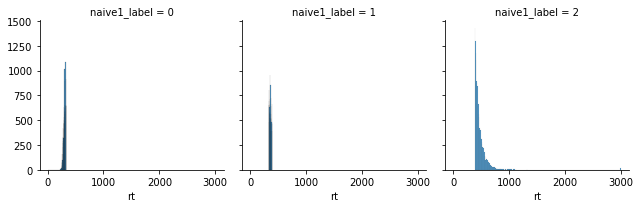

In [69]:
#Checking the distribution of each label
g = sns.FacetGrid(sorted_df, col = 'naive1_label')
g.map(sns.histplot, "rt")
plt.savefig('NAIVE1_labels.pdf')

In [70]:
#Checking the distribution of each label
label_ranges = []
for i in range(3):
    label_df = sorted_df.loc[sorted_df['naive1_label'] == i]
    max_rt = label_df['rt'].max()
    min_rt = label_df['rt'].min()
    label_ranges.append((min_rt, max_rt))
label_ranges 

[(6.0, 330.0), (330.0, 386.0), (386.0, 3000.0)]

In [71]:
#Since 330 and 386 is overlapping, we count the frequency in each class and assign 330 and 
# 386 for the highest frequency class.

no_of_330_in_0_label = sorted_df.loc[(sorted_df['naive1_label'] == 0) & (sorted_df['rt'] == 330)].shape[0]
no_of_330_in_1_label = sorted_df.loc[(sorted_df['naive1_label'] == 1) & (sorted_df['rt'] == 330)].shape[0]
no_of_386_in_1_label = sorted_df.loc[(sorted_df['naive1_label'] == 1) & (sorted_df['rt'] == 386)].shape[0]
no_of_386_in_2_label = sorted_df.loc[(sorted_df['naive1_label'] == 2) & (sorted_df['rt'] == 386)].shape[0]

no_of_330_in_0_label, no_of_330_in_1_label, no_of_386_in_1_label , no_of_386_in_2_label

(273, 46, 265, 40)

In [72]:
#Rename the labels for simple_1_rev (rev for revised) with the adjusted labels for overlapping RTs

df = sorted_df
conditions = [
    (df['rt'] <= 330),
    (df['rt'] > 330) & (df['rt'] <= 386),
    (df['rt'] > 386) 
    ]

# create a list of the values we want to assign for each condition
values = [0, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
df['rt_label_naive1'] = np.select(conditions, values)

In [73]:
#Reassign df to sorted df after dropping the old naive1 label
sorted_df = df.drop('naive1_label', axis = 1)

In [74]:
sorted_df.columns

Index(['subject', 'trial_no', 'mean_DIAM', 'var_DIAM', 'mean_LDEV', 'var_LDEV',
       'mean_RDEV', 'var_RDEV', 'rt', 'feedback', 'goal_1', 'goal_2',
       'reward_1', 'reward_2', 'rt_label_knn', 'rt_label_gaussian',
       'rt_label_naive1'],
      dtype='object')

In [75]:
df = sorted_df

features = []

X= df.drop(['rt','subject', 'rt_label_knn', 'rt_label_gaussian', 'rt_label_naive1' ], axis =1) 
y= df ['rt_label_naive1']
#Now do lazy predict
from sklearn.model_selection import train_test_split
from Lazy_predict_version_Nethali_new import Classification
#%load_ext line_profiler

#feature selection
feature_support = backward_regression(X, y, threshold_out = 0.01)
features.append(feature_support)

#Now run lazy predict on just these features from X_1
X_1 = X.get(feature_support)

random_state = [42, 35, 68, 92, 70] 
balanced_accuracy_for_problem_df_list= []
for i in range(5): #This is for manual cv
    X= X_1.astype('float')
    Y= y.astype('int')
                    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state= random_state[i])
    clf = Classification(verbose=0,ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit( X_train, X_test, Y_train, Y_test)
    balanced_accuracy_for_problem_df_list.append(models.drop(['Accuracy', 'ROC AUC', 'F1 Score', 'Time Taken'], axis = 1).rename(columns={"Balanced Accuracy":str(i)}))
#get the resulting concat df
result_df = pd.concat(balanced_accuracy_for_problem_df_list, axis=1)
#get the heighest median 
best_bal_accuracy = result_df.median(axis= 1).max()
best_classifier = result_df.median(axis= 1).idxmax()

 90%|████████▉ | 26/29 [06:09<01:19, 26.54s/it]

[19:30:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [05:55<01:17, 25.70s/it]

[19:36:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [06:02<01:19, 26.45s/it]

[19:42:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [05:58<01:16, 25.62s/it]

[19:48:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [05:49<01:18, 26.16s/it]

[19:54:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 29/29 [05:57<00:00, 12.32s/it]


In [76]:
best_bal_accuracy

0.4265615490865762

In [77]:
best_classifier

'LGBMClassifier'

In [78]:
result_df

,0,1,2,3,4
Model,,,,,
LGBMClassifier,0.43,0.43,0.43,0.42,0.43
SVC,0.42,0.43,0.42,0.42,0.42
LabelPropagation,0.42,0.43,0.42,0.43,0.42
RandomForestClassifier,0.42,0.43,0.43,0.43,0.42
LabelSpreading,0.42,0.43,0.42,0.42,0.42
AdaBoostClassifier,0.42,0.42,0.42,0.42,0.42
LogisticRegression,0.42,0.42,0.42,0.41,0.42
CalibratedClassifierCV,0.42,0.42,0.42,0.42,0.42
LinearDiscriminantAnalysis,0.42,0.42,0.42,0.41,0.42


In [79]:
features

[['trial_no',
  'mean_DIAM',
  'var_DIAM',
  'mean_LDEV',
  'var_LDEV',
  'mean_RDEV',
  'feedback',
  'goal_1',
  'goal_2',
  'reward_1']]

In [80]:
len(features[0])

10

In [81]:
#Linear Dis. Analysis was used since it can be used to do parameter tuning easily compared to LGBM and provides close 
#balanced accuracy
from sklearn.metrics import zero_one_loss, make_scorer
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import Perceptron
z1_scorer = make_scorer(zero_one_loss, normalize = False)
def tune_near_cent_para(X, Y):
    from sklearn.svm import SVC
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import balanced_accuracy_score
    solver_list = ['lsqr']
    shrinkage_list = [0.2, 0.4, 0.5, 0.6]
   #keys and values for the dictionary
    keys = []
    values = []
    std_list = []
    aic_list = []
    for i in range(len(solver_list)):
        for j in range(len(shrinkage_list)):
            model = LinearDiscriminantAnalysis(solver = solver_list[i], shrinkage = shrinkage_list[j] )
            keys.append(str(i)+str(j))
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
            cv_results = cross_validate(model, X, Y, cv=cv, return_estimator=True, scoring= 'balanced_accuracy') #X,Y same as above
            accu = cv_results['test_score'].mean()
            std = cv_results['test_score'].std()
            values.append(accu)
            std_list.append(std)
            
            cv_results2 = cross_validate(model, X, Y, cv=cv, return_estimator=True, scoring= z1_scorer)
            z1_mean = cv_results2['test_score'].mean()
            splits = [(x,y) for x, y in cv.split(X, Y)] #This gives the train and test arrays 
            n_train_samples = len(splits[0][0]) #this will give the train sample length
            aic = 2*X.shape[1] + n_train_samples*np.log(z1_mean/ n_train_samples)
            aic_list.append(aic)

    dict_nearestcent = dict(zip(keys, values)) 
    best_accuracy = max(dict_nearestcent.values())
    index_of_best_acc = np.argmax(dict_nearestcent.values()) 
    best_params_combo = [k for k, v in dict_nearestcent.items() if v == max(dict_nearestcent.values())]
    # Getting the best std and aic
    best_std = std_list[index_of_best_acc]
    best_aic = aic_list [index_of_best_acc]
    
    
    return(best_accuracy, best_params_combo, best_std, best_aic )

In [82]:
best_accuracy, best_params_combo, best_std , best_aic   = tune_near_cent_para(X, Y)

In [83]:
best_accuracy, best_params_combo, best_std , best_aic 

(0.42111562606599595, ['00'], 0.005610707948782395, -116086.36624277872)

# Simple2 classififcation (imbalanced)

In [84]:
#get the range of rt
min_val = sorted_df['rt'].min()
max_val = sorted_df['rt'].max()
no_of_vals = max_val - min_val + 1

In [85]:
no_of_vals

2995.0

In [86]:
no_of_vals/3, (no_of_vals/3)*2

(998.3333333333334, 1996.6666666666667)

In [87]:
#2995/3 = 998, 998*2 = 1996
df = sorted_df
conditions = [
    (df['rt'] <= 998),
    (df['rt'] > 998) & (df['rt'] <= 1997),
    (df['rt'] > 1997) 
    ]

# create a list of the values we want to assign for each condition
values = [0, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments
df['naive2_label'] = np.select(conditions, values)

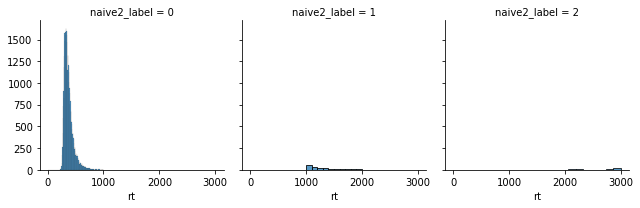

In [88]:
#checking the distribution
#Checking the distribution of each label
g = sns.FacetGrid(sorted_df, col = 'naive2_label')
g.map(sns.histplot, "rt")
plt.savefig('NAIVE2_labels.pdf')

In [89]:
#Checking the distribution of each label
label_ranges = []
for i in range(3):
    label_df = sorted_df.loc[sorted_df['naive2_label'] == i]
    max_rt = label_df['rt'].max()
    min_rt = label_df['rt'].min()
    label_ranges.append((min_rt, max_rt))
label_ranges 

[(6.0, 997.0), (999.0, 1996.0), (2060.0, 3000.0)]

In [90]:
sorted_df.columns

Index(['subject', 'trial_no', 'mean_DIAM', 'var_DIAM', 'mean_LDEV', 'var_LDEV',
       'mean_RDEV', 'var_RDEV', 'rt', 'feedback', 'goal_1', 'goal_2',
       'reward_1', 'reward_2', 'rt_label_knn', 'rt_label_gaussian',
       'rt_label_naive1', 'naive2_label'],
      dtype='object')

In [91]:
df = sorted_df

features = []

X= df.drop(['rt','subject', 'rt_label_knn', 'rt_label_gaussian','rt_label_naive1', 'naive2_label'], axis =1) 
y= df ['naive2_label']
#Now do lazy predict
from sklearn.model_selection import train_test_split
from Lazy_predict_version_Nethali_new import Classification
#%load_ext line_profiler

#feature selection
feature_support = backward_regression(X, y, threshold_out = 0.01)
features.append(feature_support)

#Now run lazy predict on just these features from X_1
X_1 = X.get(feature_support)

random_state = [42, 35, 68, 92, 70] 
balanced_accuracy_for_problem_df_list= []
for i in range(5): #This is for manual cv
    X= X_1.astype('float')
    Y= y.astype('int')
                    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state= random_state[i])
    clf = Classification(verbose=0,ignore_warnings=True, custom_metric=None)
    models, predictions = clf.fit( X_train, X_test, Y_train, Y_test)
    balanced_accuracy_for_problem_df_list.append(models.drop(['Accuracy', 'ROC AUC', 'F1 Score', 'Time Taken'], axis = 1).rename(columns={"Balanced Accuracy":str(i)}))
#get the resulting concat df
result_df = pd.concat(balanced_accuracy_for_problem_df_list, axis=1)
#get the heighest median 
best_accuracy = result_df.median(axis= 1).max()
best_method = result_df.median(axis= 1).idxmax()

 90%|████████▉ | 26/29 [01:08<00:04,  1.35s/it]

[20:33:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [01:07<00:02,  1.21s/it]

[20:34:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [01:03<00:02,  1.15s/it]

[20:35:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 90%|████████▉ | 26/29 [01:08<00:04,  1.38s/it]

[20:36:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


 93%|█████████▎| 27/29 [01:05<00:02,  1.13s/it]

[20:37:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


100%|██████████| 29/29 [01:12<00:00,  2.49s/it]


In [92]:
result_df

,0,1,2,3,4
Model,,,,,
NearestCentroid,0.53,0.39,0.63,0.39,0.44
GaussianNB,0.42,0.42,0.41,0.39,0.42
AdaBoostClassifier,0.33,0.33,0.33,0.33,0.33
LinearSVC,0.33,0.33,0.33,0.33,0.33
SVC,0.33,0.33,0.33,0.33,0.33
SGDClassifier,0.33,0.33,0.33,0.33,0.33
RidgeClassifierCV,0.33,0.33,0.33,0.33,0.33
RidgeClassifier,0.33,0.33,0.33,0.33,0.33
QuadraticDiscriminantAnalysis,0.33,0.33,0.33,0.33,0.33


In [93]:
features

[['trial_no', 'var_DIAM', 'goal_1', 'goal_2']]

In [96]:
features[0]

['trial_no', 'var_DIAM', 'goal_1', 'goal_2']

In [94]:
best_accuracy, best_method

(0.4378942755906106, 'NearestCentroid')

In [95]:
best_accuracy, best_method

(0.4378942755906106, 'NearestCentroid')

In [97]:
#parameter tuning
#Nearest Centroid parameter tuning
#list the parameters I want to tune and their values
from sklearn.metrics import zero_one_loss, make_scorer
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
z1_scorer = make_scorer(zero_one_loss, normalize = False)

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate

def tune_near_cent_para(X, Y):
    from sklearn.neighbors import NearestCentroid
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import balanced_accuracy_score
    distances_list = ['manhattan', 'euclidean']
    shrinkthres_list = [0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1, None]
   #keys and values for the dictionary
    keys = []
    values = []
    std_list = []
    aic_list = []
    for i in range(len(distances_list)):
        for j in range(len(shrinkthres_list)):
            model = NearestCentroid(metric= distances_list[i], shrink_threshold= shrinkthres_list[j] )
            keys.append(str(i)+str(j))
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)
            cv_results = cross_validate(model, X, Y, cv=cv, return_estimator=True, scoring= 'balanced_accuracy') #X,Y same as above
            
            cv_results2 = cross_validate(model, X, Y, cv=cv, return_estimator=True, scoring= z1_scorer)
            z1_mean = cv_results2['test_score'].mean()
            splits = [(x,y) for x, y in cv.split(X, Y)] #This gives the train and test arrays 
            n_train_samples = len(splits[0][0]) #this will give the train sample length
            aic = 2*X.shape[1] + n_train_samples*np.log(z1_mean/ n_train_samples)
            aic_list.append(aic)
            
            accu = cv_results['test_score'].mean()
            std = cv_results['test_score'].std()
            values.append(accu)
            std_list.append(std)

    dict_nearestcent = dict(zip(keys, values)) 
    best_accuracy = max(dict_nearestcent.values())
    index_of_best_acc = np.argmax(dict_nearestcent.values()) 
    best_params_combo = [k for k, v in dict_nearestcent.items() if v == max(dict_nearestcent.values())]
    # Getting the best std
    best_std = std_list[index_of_best_acc]
    best_aic = aic_list [index_of_best_acc]
    
    return(best_accuracy, best_params_combo, best_std , best_aic)

In [98]:
best_accuracy, best_params_combo, best_std , best_aic = tune_near_cent_para(X, Y)

In [99]:
best_accuracy, best_params_combo, best_std , best_aic

(0.46617667246259636, ['14'], 0.08752773347101116, -112038.82218952915)

In [ ]:
sorted_df.columns

In [ ]:
# Plotting the distributions in one graph

label_list = ['rt_label_knn', 'rt_label_gaussian','rt_label_naive1', 'naive2_label']

sns.histplot(data= sorted_df, x="rt", hue= label_list[0])


In [ ]:
sns.histplot(data= sorted_df, x="rt", hue= label_list[1])

In [ ]:
sns.histplot(data= sorted_df, x="rt", hue= label_list[2])

In [ ]:
sns.histplot(data= sorted_df, x="rt", hue= label_list[3])

# Scratch

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

df = new_df

x0 = df.loc[df['labels_gm'] == 0, 'max_errors']
x1 = df.loc[df['labels_gm'] == 1, 'max_errors']
x2 = df.loc[df['labels_gm'] == 2, 'max_errors']

kde0 = gaussian_kde(x0, bw_method=0.3)
kde1 = gaussian_kde(x1, bw_method=0.3)
kde2 = gaussian_kde(x2, bw_method=0.3)

xmin = min(x0.min(), x1.min(), x3.min() )
xmax = max(x0.max(), x1.max(), x3.max())
dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
xmin -= dx
xmax += dx

x = np.linspace(xmin, xmax, 150)
kde0_x = kde0(x)
kde1_x = kde1(x)
kde2_x = kde2(x)
inters_x = np.minimum(kde0_x, kde1_x, kde2_x)

#fig, ax = plt.subplots()
plt.figure(figsize=(5, 3))

plt.plot(x, kde0_x, color='b', label='zero')
plt.fill_between(x, kde0_x, 0, color='b', alpha=0.2)
plt.plot(x, kde1_x, color='orange', label='one')
plt.fill_between(x, kde1_x, 0, color='orange', alpha=0.2)
plt.plot(x, kde2_x, color='orange', label='two')
plt.fill_between(x, kde1_x, 0, color='orange', alpha=0.2)
plt.plot(x, inters_x, color='r')
plt.fill_between(x, inters_x, 0, facecolor='none', edgecolor='r', hatch='xx', label='intersection')
#plt.xticks(x)
area_inters_x = np.trapz(inters_x, x)

handles, labels = plt.gca().get_legend_handles_labels()
labels[2] += f': {area_inters_x * 100:.1f} %'
plt.legend(handles, labels)
plt.title('Max error vs label')
plt.xlabel('Max error', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.tight_layout()
plt.savefig('max_error Vs Label.pdf')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

df = feature_encoded_df

x0 = df.loc[df['rt_label'] == 0, 'rt']
x1 = df.loc[df['rt_label'] == 1, 'rt']
x2 = df.loc[df['rt_label'] == 2, 'rt']

kde0 = gaussian_kde(x0, bw_method=0.3)
kde1 = gaussian_kde(x1, bw_method=0.3)
kde2 = gaussian_kde(x2, bw_method=0.3)

xmin = min(x0.min(), x1.min(), x2.min())
xmax = max(x0.max(), x1.max(), x2.max())
dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
xmin -= dx
xmax += dx

x = np.linspace(xmin, xmax, 150)
kde0_x = kde0(x)
kde1_x = kde1(x)
kde2_x = kde2(x)
inters_x = np.minimum(kde0_x, kde1_x, kde2_x)

#fig, ax = plt.subplots()
plt.figure(figsize=(10, 3))

plt.plot(x, kde0_x, color='b', label='zero')
plt.fill_between(x, kde0_x, 0, color='b', alpha=0.2)
plt.plot(x, kde1_x, color='orange', label='one')
plt.fill_between(x, kde1_x, 0, color='orange', alpha=0.2)
plt.plot(x, kde2_x, color='green', label='two')
plt.fill_between(x, kde1_x, 0, color='green', alpha=0.2)
#plt.plot(x, inters_x, color='r')
#plt.fill_between(x, inters_x, 0, facecolor='none', edgecolor='r', hatch='xx', label='intersection')
#plt.xticks(x)
area_inters_x = np.trapz(inters_x, x)

#handles, labels = plt.gca().get_legend_handles_labels()
#labels[2] += f': {area_inters_x * 100:.1f} %'
#plt.legend(handles, labels)
plt.title('Max error vs label')
plt.xlabel('Max error', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.tight_layout()
plt.savefig('max_error Vs Label.pdf')
plt.show()

In [ ]:
#Plotting the distributions of labels to find overlapping RTs and limits for the labels.
#plt.figure(figsize=(10,3))
#plt.xticks([0, 440, 760], rotation = 90) 
#sns.displot(data= feature_encoded_df, x = 'rt', hue = 'rt_label_knn1')
#plt.savefig("KNNdistributions.png")